<a href="https://colab.research.google.com/github/d4rkl0rd3r3b05/AutoSuggestionTableViewController/blob/master/Android_App_Review_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00


In [18]:
import matplotlib.pyplot as plt
import numpy as np

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')


# 1️⃣ Fetch Reviews from Google Play Store 🛍️

In [13]:
from google_play_scraper import app, reviews

# Fetch app details and reviews
result, continuation_token = reviews(
    'com.kfc.me',
    lang='en',
    country='us',
    count=100  # Number of reviews to fetch
)

result[:3], len(result)


([{'reviewId': '3f0c2dd9-0c3f-42b0-8ab7-22259e739ffa',
   'userName': 'Khalid Alderei',
   'userImage': 'https://play-lh.googleusercontent.com/a-/ALV-UjXFnJaoeUNDLKdUK0fysCHeBq-RFIHQcuyWW9o-pSR0I2PO-aE',
   'content': "Hi, I ordered happy 53RD Eid Al Etihad offer ( Wed, Nov 27) and the food came to me not delicious and chicken were black I means overcook not fresh, it's very bad, what is this, are you joking with us?, I don't wanna say bad words to you all, I will delete the app N I will never order from KFC again, bye",
   'score': 1,
   'thumbsUpCount': 0,
   'reviewCreatedVersion': '9.15.1',
   'at': datetime.datetime(2024, 11, 26, 23, 15, 35),
   'replyContent': None,
   'repliedAt': None,
   'appVersion': '9.15.1'},
  {'reviewId': 'efd6b7c4-246b-4399-871d-8b43f6cd3bb6',
   'userName': 'ali asghar',
   'userImage': 'https://play-lh.googleusercontent.com/a-/ALV-UjUFaw0BOwUKPXR3EJOh2nYvSIigrq-f4TUcsDPJNew2oVcuuKjr',
   'content': 'Better than anything loved the app',
   'score': 5,
 

#2️⃣ Analyze Sentiments with Hugging Face 🤖

In [14]:
from transformers import pipeline

# Initialize Hugging Face sentiment analysis pipeline
classifier = pipeline('sentiment-analysis')

# Analyze review sentiments
sentiments = [classifier(review['content'])[0] for review in result]
for sentiment in sentiments[:5]:
    print(sentiment)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'label': 'NEGATIVE', 'score': 0.9995076656341553}
{'label': 'POSITIVE', 'score': 0.9992619156837463}
{'label': 'POSITIVE', 'score': 0.9998681545257568}
{'label': 'POSITIVE', 'score': 0.9989953637123108}
{'label': 'NEGATIVE', 'score': 0.9894389510154724}


#3️⃣ Group Reviews by Themes 📂

In [16]:
from transformers import pipeline

# Initialize the zero-shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define possible themes for classification
themes = ["Bug Report", "Feature Request", "Performance Issue", "UI/UX Improvement", "General Feedback", "Delivery Issue", "Food Quality"]

# Classify each review
review_texts = [review['content'] for review in result]
classified_reviews = [{"text": text, "label": classifier(text, themes)['labels'][0]} for text in review_texts]

# Group reviews by themes
grouped_reviews = {theme: [] for theme in themes}
theme_counts = {theme: 0 for theme in themes}

for review in classified_reviews:
    grouped_reviews[review["label"]].append(review["text"])
    theme_counts[review["label"]] += 1


print(grouped_reviews)


{'Bug Report': ['KFC food caused severe food poisoning', 'Got my 5000+ loyalty points expiring today 15th and it is not even the 16th but you already removed and expired it. Was planning to redeem and order something else. Not even a good way to keep loyal customers. Might as well be loyal to others fast-food brands.'], 'Feature Request': ['Crazy food', "As a regular KFC customer, I'm disappointed that redeeming the points, accumulated as a loyal customer, applies as a coupon on the app. Ideally, the item redeemed using points should be updated directly in the cart and customer should not have to select the redeemed item as a coupon again. I should be able to use my reward points and any other promo coupon as well rather than restricting customers to any one option.", 'Fast delivery service'], 'Performance Issue': ["I try to placed again and again but this app did not give me response I click submit but it doesn't work and doesn't placed my order . Plz help me", "Too bad Service oder w

#4️⃣ Visualize with a Bubble Chart 🫧

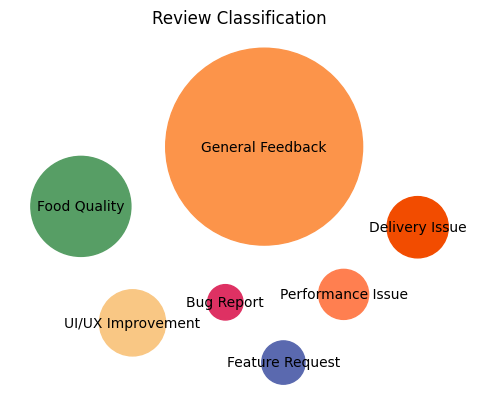

In [82]:
theme_counts = {key: len(value) for key, value in grouped_reviews.items()}
import matplotlib.pyplot as plt
import numpy as np


color = ['#DE3163','#5A69AF', '#FF7F50', '#F9C784', '#FC944A', '#F24C00', '#579E65']
bubble_chart = BubbleChart(area=list(theme_counts.values()),
                           bubble_spacing=2)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, list(theme_counts.keys()), color)
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Review Classification')

plt.show()

# 5️⃣ Conduct Gap Analysis 📉

In [7]:
from collections import Counter

# Gap analysis: word frequency in negative reviews
negative_reviews = [review['content'] for review, sentiment in zip(result, sentiments) if sentiment['label'] == 'NEGATIVE']
word_counts = Counter(" ".join(negative_reviews).split())
common_issues = word_counts.most_common(10)

print("Top Issues:", common_issues)


Top Issues: [('the', 24), ('to', 21), ('I', 18), ('and', 18), ('from', 12), ('is', 9), ('order', 8), ('but', 8), ('food', 7), ('not', 7)]
